# Gaussianization with flows: a demo for ENUSA 

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax
from sklearn import datasets

import torch
from torch import nn

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer

In [2]:
%matplotlib inline
plt.ioff()
PI = torch.Tensor([math.pi])
dev = torch.device('cpu')

In [23]:
def create_animation(init_data, intermediate_results):
    
    preds = init_data
    
    fig, ax = plt.subplots(figsize=(6, 6))

    sc = ax.scatter(preds[:, 0], preds[:, 1])

    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xlabel('Variable 1')
    ax.set_ylabel('Variable 2')
    ax.set_title('Iteración 0')
    
    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets = preds
        ax.set_title('Iteración {:d}'.format(i*10))

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

In [19]:
def create_steps_animation(X, model):
    
    zs, _ = model(X)
    
    zs
    
    fig, ax = plt.subplots(figsize=(6, 6))

    sc = ax.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1])

    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)

    def update_scat(i):
        preds = zs[i]
        sc._offsets = preds.detach().numpy()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(zs), interval=1500)
    
    return ani

### Generating data

In [5]:
n_samples = 1000
dim = 2

In [6]:
x = np.random.rand(n_samples)-0.5
y = 2**(5*x) + 0.5*np.random.randn(n_samples) - 3

X_torch = torch.as_tensor(np.array([x, y]).T, dtype=torch.float).to(dev)

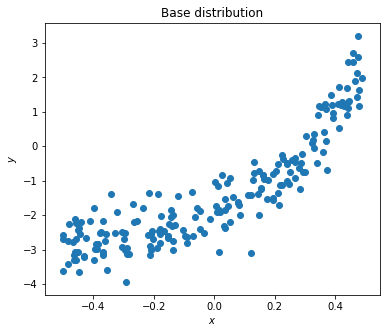

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(x[:200], y[:200])
ax.set_title('Base distribution')
ax.set_ylabel(r'$y$')
ax.set_xlabel('$x$')

plt.show()

### Build and train Flow

In [8]:
epochs = 30000

In [9]:
model = Flow(layers=[NvpCouplingLayer(dim) for _ in range(10)]).to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

loss = []
logpz = []
logdet = []

intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    
    preds, _logdet = model(X_torch)
    
    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(-0.5 * (torch.log(2*PI)*dim + torch.sum(preds[-1]**2, dim=1)))
    _loss = -_logpz - _logdet

    optimizer.zero_grad()
    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")
        intermediate_results.append(preds[-1].detach().cpu().numpy()[:200])

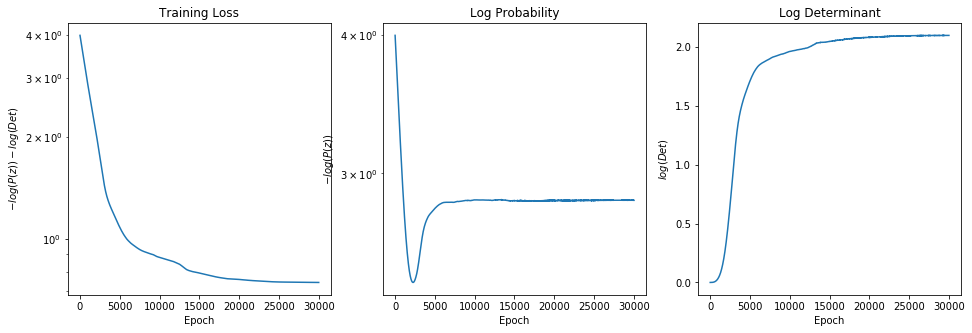

In [10]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss)
ax[1].plot(-np.array(logpz))
ax[2].plot(logdet)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$-log(P(z))$')
ax[1].set_yscale('log')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

In [25]:
ani = create_animation(np.array([x, y]).T[:200], intermediate_results)

In [26]:
HTML(ani.to_html5_video())

In [13]:
ani_steps = create_steps_animation(X_torch[:200], model.cpu())

In [14]:
HTML(ani_steps.to_html5_video())